In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time

from scipy.sparse.linalg import eigsh
from sklearn.base import BaseEstimator
from sklearn import linear_model

In [3]:
# Data Preparation
n=1000
d=10
alpha = 0.3


n_corr  = int(alpha*n)

Idx= np.random.permutation(n)
corrIdx= np.sort(Idx[0:n_corr])
cleanIdx=np.sort(Idx[n_corr:n])



X = np.random.normal(0,1, (n, d))/np.sqrt(d)


w_star= np.random.normal(0,1, (d, 1))
w_star = w_star / np.linalg.norm(w_star)

w_adv= np.random.normal(0,1, (d, 1))
w_adv -= np.dot(w_adv.transpose(),w_star)*w_star
w_adv = w_adv / np.linalg.norm(w_adv)

eta=np.zeros(shape=(n,1))
eta[cleanIdx] = np.dot(X[cleanIdx,:], w_star)
eta[corrIdx] = np.dot(X[corrIdx,:], w_adv)


print("Running with corruption but no-noise.")
y=(eta>0)*1

corrIdx_true=[]

for idx in corrIdx:
    if y[idx]!=(np.dot(X[idx,:], w_star)>0)*1:
        corrIdx_true.append(idx)
        
corrIdx_true=np.array(corrIdx_true)
true_corr_frac = len(corrIdx_true)/n
cleanIdx_true=np.append(cleanIdx, np.setdiff1d(corrIdx,corrIdx_true))        
w_init=w_adv

Running with corruption but no-noise.


In [4]:
len(corrIdx_true), len(corrIdx), len(cleanIdx), len(cleanIdx_true), y.shape

(143, 300, 700, 857, (1000, 1))

In [5]:
class SVAM_LR(BaseEstimator):
# w_star is used only to plot convergence curves and not tune the method or decide stopping criterion in any way
    def __init__( self, beta_init = 0.01 , eta = 1.1, w_init = None, w_star = None ):
        self.eta = eta
        self.alpha = alpha
        self.beta_init = beta_init
        self.w_init = w_init
        self.w_star = w_star

    def fit( self, X, y, beta_max=1, max_iter = 500, max_iter_inner = 5 ):
        start_time=time.time()
        n, d = X.shape
        beta = self.beta_init
        self.w = self.w_init
        self.l2=[]
        self.clock=[]
        itr=0         
        clf=linear_model.LogisticRegression(solver='newton-cg',max_iter=100, penalty=None,warm_start=True)
        while itr < max_iter:
            for _ in range(max_iter_inner):
                temp=np.dot(X,self.w)
                pi=np.zeros(shape=(n,1))
                pi[temp>100]=1
                pi[temp<-100]=0
                idx = (temp <= 100) & (temp >= -100)
                pi[idx] = 1/(1+np.exp(-temp[idx]))

                p=np.power(pi,beta)/(np.power(pi,beta)+np.power(1-pi,beta))
                s=p*y+(1-p)*(1-y)
                clf.fit(X,y.ravel(),sample_weight=s.ravel())
                self.w=clf.coef_.transpose()
                self.l2.append(np.linalg.norm(self.w/np.linalg.norm(self.w)-w_star))
                self.clock.append(time.time()-start_time)
            itr=itr+max_iter_inner
            beta=min(beta_max,self.eta*beta)
        return self

    def predict( self, X ):
        return (np.dot( X, self.w ) > 0)*1

    def score( self, X, y ):
        n_test = X.shape[0]
        return -np.linalg.norm(y - self.predict(X), 2) / np.sqrt( n_test )    

In [6]:
#------------SVAM-LR--------------#

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

cross_validation=True
if cross_validation:
    eta_range = np.linspace( 1.01, 2, 20 )
    beta_init_range = np.power( 10.0, [-2, -1] )
    
    param_grid = dict( beta_init = beta_init_range, eta = eta_range)
    cv = ShuffleSplit( n_splits = 1, test_size = 0.3, random_state = 42 )
    grid = GridSearchCV( SVAM_LR( w_init = w_adv, w_star = w_star ), param_grid=param_grid, cv = cv, refit = False )
    grid.fit( X, y )
    best = grid.best_params_
    print("The best parameters for SVAM are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    svam = SVAM_LR( beta_init = best['beta_init'], eta = best["eta"], w_init = w_adv, w_star = w_star )
else:
    svam = SVAM_LR( beta_init = 0.01, eta = 1.1, w_init = w_adv, w_star = w_star )

svam.fit( X, y,  max_iter = 2500)
l2_svam = svam.l2
clock_svam = svam.clock
print('SVAM_LR: ',l2_svam[-1],'Time taken: ',clock_svam[-1])

The best parameters for SVAM are {'beta_init': np.float64(0.01), 'eta': np.float64(1.635263157894737)} with a score of -0.42
SVAM_LR:  0.09822918405873302 Time taken:  7.196512699127197


In [7]:
#------------VAM-LR------------#
betas=[0.01,1,10]

vam = SVAM_LR( beta_init = betas[0] , eta = 1, w_init = w_adv, w_star = w_star )
vam.fit( X, y,  max_iter = 2500)
l2_vam_0 = vam.l2
clock_vam_0 = vam.clock
print('VAM_LR: ',l2_vam_0[-1],'Time taken: ',clock_vam_0[-1])


vam = SVAM_LR( beta_init = betas[1] , eta = 1, w_init = w_adv, w_star = w_star )
vam.fit( X, y,  max_iter = 2500)
l2_vam_1 = vam.l2
clock_vam_1 = vam.clock
print('VAM_LR: ',l2_vam_1[-1],'Time taken: ',clock_vam_1[-1])

vam = SVAM_LR( beta_init = betas[2] , eta = 1, w_init = w_adv, w_star = w_star )
vam.fit( X, y,  max_iter = 2500)
l2_vam_2 = vam.l2
clock_vam_2 = vam.clock
print('VAM_LR: ',l2_vam_2[-1],'Time taken: ',clock_vam_2[-1])

VAM_LR:  0.3730205035943806 Time taken:  7.243619203567505
VAM_LR:  0.11007195481346164 Time taken:  7.137365818023682
VAM_LR:  1.1138820899639985 Time taken:  9.844353437423706


In [8]:
#---------Logistic Regression---------#

start=time.time()
clf=linear_model.SGDClassifier(loss='log_loss',max_iter=1000, penalty=None)
clf.fit(X,y.ravel())
clf.get_params()
w1=clf.coef_
w1=w1/np.linalg.norm(w1)
end=time.time()
clock_logistic=end-start
l2_logistic=np.linalg.norm(w1.transpose()-w_star)
print('Logistic Regression: ',l2_logistic, 'Time taken: ',clock_logistic)

Logistic Regression:  0.423894072011241 Time taken:  0.010315656661987305


In [9]:
#---------Oracle---------#

start=time.time()
clf=linear_model.SGDClassifier(loss='log_loss',max_iter=1000, penalty=None)
clf.fit(X[cleanIdx],y[cleanIdx].ravel())
clf.get_params()
w1=clf.coef_
w1=w1/np.linalg.norm(w1)
end=time.time()
clock_oracle=end-start
l2_oracle=np.linalg.norm(w1.transpose()-w_star)
print('Logistic Regression: ',l2_logistic, 'Time taken: ',clock_logistic)

Logistic Regression:  0.423894072011241 Time taken:  0.010315656661987305


Text(0.5, 1.0, 'n=1000 d=10 alpha=0.143')

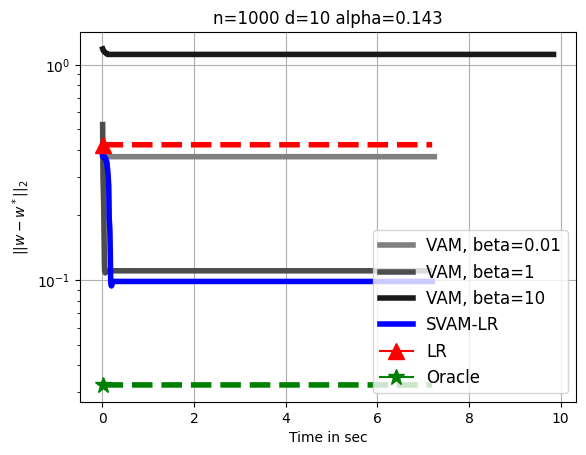

In [10]:
import matplotlib.pyplot as plt
import numpy as np

n=1000
d=10
alpha=0.3
file_name='logistic_no_noise'

plt.semilogy(clock_vam_0, l2_vam_0, label = 'VAM, beta={}'.format(str(betas[0])),marker=',',markersize='8',linewidth=4,color='0.5')
plt.semilogy(clock_vam_1, l2_vam_1, label = 'VAM, beta={}'.format(str(betas[1])),marker=',',markersize='8',linewidth=4,color='0.3')
plt.semilogy(clock_vam_2, l2_vam_2, label = 'VAM, beta={}'.format(str(betas[2])),marker=',',markersize='8',linewidth=4,color='0.1')


plt.semilogy(clock_svam, l2_svam, label = 'SVAM-LR',marker=',', color='blue',markersize='8',linewidth=4)


clock_svam[0]=clock_logistic
plt.semilogy(clock_logistic,l2_logistic,marker='^',color='red',markersize='12',label = 'LR')
plt.semilogy(clock_svam, np.ones(len(clock_svam))*l2_logistic,ls='--', linewidth=4,color='red')

clock_svam[0]=clock_logistic
plt.semilogy(clock_oracle,l2_oracle,marker='*',color='green',markersize='12',label = 'Oracle')
plt.semilogy(clock_svam, np.ones(len(clock_svam))*l2_oracle,ls='--', linewidth=4,color='green')

plt.legend(prop = {'size': 12},loc='lower right')
plt.xlabel('Time in sec')
plt.ylabel('$||w-w^*||_2$')
plt.grid()
plt.title('n='+str(n)+' d='+str(d)+' alpha='+str(true_corr_frac))
#plt.savefig(file_name+'.pdf')